In [1]:
%pylab inline
import pandas as pd
# Let's try to train a fraction of the parameters.
#
import os
homedir = os.path.expanduser('~')

subsample=1
TEST_subsample=1
my_optimizer='sgd'
epochs = 200
checkpointPaths = []
finerRange = list(arange(0,.1,.01))#[1:])
coarseRange = list(arange(.1,1,.3))
absoluteRange = [1,5,10]


#finerRange = finerRange[-2:-1]
#coarseRange=[.1]
absoluteRange = [5,10,1]

def countParams(m,mm=False):
    if mm:
        return (sum(p.numel() for p in m.parameters() if p.requires_grad)/1000000.0)
    else:
        return (sum(p.numel() for p in m.parameters() if p.requires_grad))

#archs = ['densenet_partial','wrn_partial']
#archs = ['squeezenet1_1_partilimital','densenet_partial','wrn_partial','vgg19_bn_partial','alexnet_partial','vgg19_partial',]#,'alexnet_partial']
archs = ['densenet_partial','wrn_partial','vgg19_bn_partial','alexnet_partial','vgg19_partial',]#,'alexnet_partial']
#archs = ['vgg19_bn_partial']

datasets = ['cifar10','cifar100']
#archs = ['wrn_partial']
if False:
    coarseRange = [.1]
    finerRange = []
    absoluteRange = [1,5]#,10]
kill_fixed_s = [False,True]
pp=0
verbose=False
from itertools import product
fast_schedule = False
status = []


def make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,kill_fixed,dataset='cifar10',train_only='train_all',
                        learn_bn=True):
    P = arch_to_name_prefix[arch]
    checkpointPath = os.path.join(ckpt_base_dir,
                                  '{f_arch}_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.
                                  format(f_arch=P,bb=frac,iter_=iter_,opt=my_optimizer,s=subsample))
    if kill_fixed:
        checkpointPath += '_zero_fixed'
        
    #if frac >= 1:# a fixed integer amount of filters.
    #    checkpointPath += '_I'
    if dataset != 'cifar10':
        checkpointPath += '_C100'
        
    if fast_schedule:
        checkpointPath += '_FS'        
        
    if train_only!='train_all':
        checkpointPath += '_only_{}'.format(train_only)
    if not learn_bn:
        checkpointPath += '_no-bn'
    return checkpointPath
optimizers = ['sgd']

iters = [0]
#fracs =  finerRange+coarseRange+absoluteRange#coarseRange+absoluteRange
fracs =  coarseRange+absoluteRange+finerRange


resnetWidth = 4
LIMIT_EPOCHS = 10

LIMIT_EPOCHS = 10
learn_bns = [True]
train_onlys = ['conv1','block1','block2','block3','fc','train_all']
#archs = ['densenet_partial','wrn_partial']
if LIMIT_EPOCHS < 0:
    #fracs = [-1]+[0]+[0.1,0.4,0.7,1]    
    fracs = [0.1,0.4,0.7,-1,1]
    resnetWidth=10
    archs = ['densenet_partial','wrn_partial']
    kill_fixed_s = [False]
    #archs = ['densenet_partial']
    train_onlys = ['train_all']
    learn_bns = [True]
else:
    #fracs = #[-1] + [0] + fracs
    fracs = [0] +[-1]+ fracs
    learn_bns = [True,False]
    train_onlys+=['train_nothing']
if False:
    if LIMIT_EPOCHS == 1:
        archs = ['densenet_partial','wrn_partial']
        #fracs = [0.1,1]
        fracs = [0] + fracs
        fracs = [p for p in fracs if p == 0 or p>=0.1]
        learn_bns = [True,False]
        train_onlys = ['conv1','block1','block2','block3','fc','train_all','train_nothing']#['train_all','train_nothing']
        kill_fixed_s = [False]
    
all_opts = list(product(fracs,datasets,optimizers,archs,kill_fixed_s,iters,train_onlys,learn_bns))
opts_with_state=[]
ddd = []
dfs = {}

DDD = '/home/amir/checkpoints/cifar10/'
ckpt_base_dir = DDD
arch_to_name_prefix = {'squeezenet1_1_partial':'SQZ-frac',\
    'vgg19_partial':'VGG-frac',\
                       'vgg19_bn_partial':'VGG-BN-frac',\
                       'alexnet_partial':'ALEXNET-frac','wrn_partial':'WRN-28-{}-frac'.format(resnetWidth),'densenet_partial':'densenet-bc-100-12'}
arch_to_params = {'alexnet_partial':dict(epochs=164,lr_sched='81 122'),
                  'squeezenet1_1_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_bn_partial':dict(epochs=164,lr_sched='81 122'),
                  'wrn_partial':dict(epochs=200,lr_sched='60 120 160'),
                  'densenet_partial':dict(epochs=300,lr_sched='150 225')}
import matplotlib.patches as patches
PRINT_CMD=True
covered_paths = {}


'''



# "conv1,block_i,fc" should have -1
# allow fraction of -1 for "train all / train nothing" only. 
df_opts = df.drop(df[(~df.to_train_only.isin(['train_all','train_nothing'])) & (df.frac != -1)].index)

'''

for frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only,learn_bn in all_opts:
    arch_= arch
       
    #if frac == -1:
    #    to_train_only = 'train_all'
    #    kill_fixed=False
    if False:
        # SPECIAL TREATMENT OF SQUEEZENET
        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #
        if 'squeeze' not in arch:
            continue    
        if not(frac >= .1 or frac == -1):
            continue
        if to_train_only != 'train_all':
            continue  
        if learn_bn == False:
            continue
        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #

        #print frac,dataset,arch,kill_fixed,to_train_only,learn_bn

       
    if to_train_only != 'train_all' and learn_bn==False:
        continue
    if frac > 0 and frac < 0.07:
        continue
    if to_train_only == 'train_all' and frac == 0:
        continue
      
    if to_train_only == 'train_all' and frac == -1:
        arch_=arch.replace('_partial','')
    
     
    if to_train_only == 'train_nothing' and frac != 0:
        continue
        
    if frac == 0 and to_train_only != 'train_nothing':
        continue
   
        
    if to_train_only in ['conv1','block1','block2','block3','fc']:
        frac = -1
  
    #if not 'wrn' in arch and not 'dense' in arch:
    #    continue
    
   
    if learn_bn == False:
        if not 'wrn' in arch and not 'dense' in arch:
            continue
   
    #if to_train_only != 'train_all':
    #    learn_bn = False
    if to_train_only in ['conv1','block1','block2','block3','fc']:
        learn_bn = True
    
    if to_train_only == 'train_nothing': 
        if frac != 0 or learn_bn == False:
            continue
        if not 'wrn' in arch and not 'dense' in arch:
            continue
    
    if to_train_only != 'train_all':
        if not 'wrn' in arch and not 'dense' in arch:            
            continue
        else:
            frac = -1
            kill_fixed=False
            arch_=arch.replace('_partial','')
   
    n_epochs = arch_to_params[arch]['epochs']

    if fast_schedule:
        n_epochs=10

    if LIMIT_EPOCHS > 0:
        n_epochs = min(LIMIT_EPOCHS,n_epochs)            
        ckpt_base_dir = DDD + 'LIMIT_EPOCHS'
    if frac > 0 and frac * 16 < 1: # check if there are no non-zero parameters in the first layer.
        #print('continuing on frac:',frac)
        continue
    
    epochs = n_epochs
    if my_optimizer.lower()=='adam':
        epochs=10
    if frac == 0 and kill_fixed:
        epochs = 1

    checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                         kill_fixed,dataset,to_train_only,learn_bn)                        

    checkpointPaths.append(checkpointPath)

    if 'wrn' in arch:
        cmd = 'python cifar.py -a {arch} --depth 28 --widen-factor {resnetWidth} --train-batch 128 --drop 0.3 --wd 5e-4 --gamma 0.2 --epochs {epochs}'.\
        format(resnetWidth=resnetWidth,arch=arch_,epochs=epochs)
    elif 'dense' in arch:                
        cmd = 'python cifar.py -a {arch} --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs)
    elif 'alexnet' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'vgg' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'squeeze' in arch:
        cmd = 'python cifar.py -a {arch} --lr 0.04 --wd 2e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    cmd += ' --checkpoint {checkpoint}'
    #cmd += ' --only-layer {retrain_layer}'

    lr=.1 if my_optimizer == 'sgd' else 1e-3

    cmd = cmd.format(checkpoint = checkpointPath)#,retrain_layer=retrain_layer)
    cmd += ' --start-epoch 0'
    cmd += ' --learn-bn {}'.format(learn_bn)        
    cmd += ' --lr {}'.format(lr)
    cmd += ' --optimizer {}'.format(my_optimizer)
    cmd += ' --subsample {}'.format(subsample)
    cmd += ' --test-subsample {}'.format(TEST_subsample)
    cmd += ' --zero-fixed-part {}'.format(kill_fixed)
    cmd += ' --part {frac}'.format(frac=frac)            
    if fast_schedule:
        cmd += ' --schedule 4 4'
    else:
        cmd += ' --schedule {}'.format(arch_to_params[arch]['lr_sched'])


    cmd += ' --dataset {}'.format(dataset)

    if frac == -1 and to_train_only != 'train_all':
         cmd += ' --only-layer {}'.format(to_train_only)
    #cmd += ' --schedule 10 20'

    logFilePath = os.path.join(checkpointPath,'log.txt')
    if logFilePath in covered_paths:
        continue
    else:
        covered_paths[logFilePath]=1
    paramCountPath = os.path.join(checkpointPath,'n_params.txt')
    #frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only 
    curOpts = dict(my_optimizer=my_optimizer,arch=arch,dataset=dataset,kill_fixed=kill_fixed,frac=frac,logFilePath=logFilePath,
                  train_only=to_train_only,learn_bn=learn_bn)
    
    #try:
    #    n_params = open(paramCountPath).readlines()
    #    n_params = [int(p.strip().split()[-1]) for p in n_params]
    #except:
    #    print(cmd + ' --print-params-and-exit True\n');continue
    #continue
    
    #print(cmd + ' --print-params-and-exit True\n');continue
    if os.path.isfile(logFilePath):
        logData = open(logFilePath).readlines()

        try:
            n_params = open(paramCountPath).readlines()
            n_params = [int(p.strip().split()[-1]) for p in n_params]
        except:
        
            n_params = [-1 -1]
            
        nRows = len(logData)
        if nRows < epochs + 1:
            curOpts['ok']=False
            curOpts['message']='not enough rows'
            if verbose:
                print 'found log file but number of rows was',nRows
                print checkpointPath                    
        elif nRows >= epochs+1:
            curOpts['ok'] = True
            curOpts['message'] = 'found.'                
            try:

                dfs[frac] = pd.read_table(logFilePath)
                curValidAcc = dfs[frac]['Valid Acc.'][:epochs].max()               
                ddd.append(dict(frac=frac,arch=arch,dataset=dataset,fast_schedule=fast_schedule,kill_fixed=kill_fixed,
                                optimizer=my_optimizer,valid_acc=curValidAcc,all_accs=dfs[frac]['Valid Acc.'],train_only=to_train_only,
                                active_params = n_params[0],total_params=n_params[1],learn_bn=learn_bn))
            except e:
                #raise(e)
                print 'FAILED LOADING',logFilePath                
                pass        
    else:
        curOpts['ok']=False
        curOpts['message']='file not found'
        if verbose:
            print 'could not find log file for {},{},{},{},{},{}'.format(my_optimizer,arch,dataset,kill_fixed,frac_,iter_)
            print 'directory:',checkpointPath
            #break
    if not curOpts['ok']:            
        # not ok, needs to be computed. 
        PRINT_CMD=True
        if PRINT_CMD: print(cmd)
        #pass
    opts_with_state.append(curOpts)
    pp+=1
print
print
import seaborn as sns
#sns.set_style('ticks')
#sns.set_context('paper',font_scale=1.5)
rn = {'valid_acc':'% Accuracy','kill_fixed':'zero_fixed'}
print 
printw

Populating the interactive namespace from numpy and matplotlib
python cifar.py -a vgg19_bn --wd 1e-4 --gamma 0.1 --epochs 10 --checkpoint /home/amir/checkpoints/cifar10/LIMIT_EPOCHS/VGG-BN-frac_-1_iter_0_opt_sgd_subsample_1 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part -1 --schedule 81 122 --dataset cifar10
python cifar.py -a vgg19_bn --wd 1e-4 --gamma 0.1 --epochs 10 --checkpoint /home/amir/checkpoints/cifar10/LIMIT_EPOCHS/VGG-BN-frac_-1_iter_0_opt_sgd_subsample_1_zero_fixed --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part True --part -1 --schedule 81 122 --dataset cifar10
python cifar.py -a alexnet --wd 1e-4 --gamma 0.1 --epochs 10 --checkpoint /home/amir/checkpoints/cifar10/LIMIT_EPOCHS/ALEXNET-frac_-1_iter_0_opt_sgd_subsample_1 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part -1 

# Ensemble

In [2]:
# Let's define model ensembles.
start_ckpt = '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_-1_iter_1_opt_sgd_subsample_1_ENS/model_best.pth.tar'

ensemble_configs = [dict(frac=-1,share_params=True,is_fc=False), # start with 1 pre-trained, train all params
                    dict(frac=-1,share_params=True,is_fc=True), # start with 1 pre-trained, retrain only fc layer
                    dict(frac=0.1,share_params=True,is_fc=False), # start with 1 pre-trained, retrain 0.1 of parameters + fc
                    dict(frac=0.4,share_params=True,is_fc=False), # start with 1 pre-trained, retrain 0.4 of parameters + fc
                    dict(frac=0.7,share_params=True,is_fc=False) # start with 1 pre-trained, retrain 0.7 of parameters + fc
                    ]
ensemble_size=5

In [3]:
# Make a cheap ensemble with densenets.
arch='densenet_partial'
epochs = 1
dirs = []
# test the following scenarios:
# 1. independently trained ensemble elements
# 2. train once, retrain only fc layer
# 3. train once, retrain some part of the conv layers
learn_bn=True
kill_fixed=False
dataset='cifar10'    

firstCheckpoint=None
#my_optimizer = 'yf'
for my_optimizer in ['adam','sgd']:
    if my_optimizer=='adam':
        lr = 1e-3
    else:
        lr=1e-1
    for cfg in ensemble_configs:    
        frac = cfg['frac']
        is_fc = cfg['is_fc']
        if is_fc:
            to_train_only = 'fc'
        else:
            to_train_only = 'train_all'
        share_params = cfg['share_params']
        if False:
            print '---------------------------------------'
            print cfg
            print '---------------------------------------'
        for iter_ in range(1,ensemble_size+1):
            the_arch = 'densenet_partial'
            if frac == -1:
                the_arch = 'densenet'
            cmd = 'python cifar.py -a {arch} --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=the_arch,epochs=epochs)
            cmd += ' --checkpoint {checkpoint}'                
            checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                                     kill_fixed,dataset,to_train_only,learn_bn)
            checkpointPath+='_ENS'    

            # Allow independent models only for the full one.
            if frac==-1 and not is_fc and share_params:            
            #if not share_params:
                checkpointPath += '_IND'
            lr=.1 if my_optimizer == 'sgd' else 1e-3
            cmd = cmd.format(checkpoint = checkpointPath)#,retrain_layer=retrain_layer)
            cmd += ' --start-epoch 0'
            cmd += ' --learn-bn {}'.format(learn_bn)        
            cmd += ' --lr {}'.format(lr)
            cmd += ' --optimizer {}'.format(my_optimizer)
            cmd += ' --subsample {}'.format(subsample)
            #cmd += ' --optimizer yf'
            cmd += ' --test-subsample {}'.format(TEST_subsample)
            cmd += ' --zero-fixed-part {}'.format(kill_fixed)
            cmd += ' --part {frac}'.format(frac=frac)        
            if fast_schedule:
                cmd += ' --schedule 10 20'
            else:
                cmd += ' --schedule {}'.format(arch_to_params[arch]['lr_sched'])
            cmd += ' --dataset {}'.format(dataset)
            if share_params:
                cmd+= ' --load-fixed-path {}'.format(start_ckpt)        
            if to_train_only != 'train_all':
                cmd += ' --only-layer {}'.format(to_train_only)

            dirs.append(dict(share_params=share_params,frac=frac,checkpointPath=checkpointPath,is_fc=is_fc,my_optimizer=my_optimizer,
                            cmd=cmd))
            logFilePath = os.path.join(checkpointPath,'log.txt')
            #print logFilePath
            if os.path.isfile(logFilePath):
                logData = open(logFilePath).readlines()
                nRows = len(logData)
                if nRows >= epochs+1:
                    #pass
                    #print 'skipping:',cmd
                    #print 'CCC'
                    continue
            print cmd    
    print


In [4]:
cd ~/code/pytorch-classification/

/home/amir/Dropbox/code/pytorch-classification


In [5]:

from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import argparse
import os
import shutil
import time
import random
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models.cifar as models
criterion = nn.CrossEntropyLoss()
def test1(testloader, model, criterion, epoch, use_cuda,max_batches=10**6):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    # switch to evaluate mode
    model.eval()
    all_targets = []
    all_outputs = []
    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if batch_idx >= max_batches:
            break
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        all_targets.append(targets.cpu().numpy())
        all_outputs.append(outputs.cpu().data.numpy())
        top1.update(prec1[0], inputs.size(0))
    all_outputs = concatenate(asarray(all_outputs))
    all_targets = concatenate(all_targets)
    return all_targets,all_outputs, losses.avg, top1.avg

/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
import pandas as pd
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets
dataloader = datasets.CIFAR10
criterion = nn.CrossEntropyLoss()
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
dataset = 'cifar10'
testset = dataloader(root='/home/amir/'+dataset, train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)#sampler=data.sampler.SubsetRandomSampler(indices=range(500)))

frac_to_p = dict(zip([-1, 0, 0.1, 0.2,.4],[770000,27000,90000,162000,305000]))

for a,b in frac_to_p.items():
    print a,(770000+9*b)/10.**6
df = pd.DataFrame(dirs)
from torch.autograd import Variable
import time
from torch.autograd import Variable
all_res = []
print '--------------------------------'
df = pd.DataFrame(dirs)
for frac,share_params,is_fc,optimizer in set(zip(df.frac,df.share_params,df.is_fc,df.my_optimizer)):
    df1 = df[(df.is_fc==is_fc)&(df.frac==frac)&(df.share_params==share_params)&(df.my_optimizer==optimizer)]
    print 'LEN:',len(df1)
    print frac,share_params,is_fc,optimizer
    print '--------------------------------'
    #continue
    if frac==0.9 and share_params == False:
        continue
    TT = []
    OO = []
    accs = []
    total_params = 0
    for cur_dir in list(df1.checkpointPath):
        try:
                #print cur_dir
            print '.',
            if frac == -1:
                model = models.densenet(depth=100,  dropRate=0, num_classes=10, growthRate=12, compressionRate=2)
            else:                                        
                model = models.densenet_partial(depth=100,  dropRate=0, num_classes=10, growthRate=12, compressionRate=2,part=frac,zero_fixed_part=False,do_init=False,split_dim=0)

            #modelPath = '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_{}_opt_sgd_subsample_1_only_train_nothing_ENS/model_best.pth.tar'.format(iter_)
            modelPath = os.path.join(cur_dir,'model_best.pth.tar')
            if not os.path.isfile(modelPath):
                continue
            model = torch.nn.DataParallel(model).cuda()
            model_dict = torch.load(modelPath)['state_dict']
            n_params = open(modelPath.replace('model_best.pth.tar','n_params.txt')).readlines()
            n_params = [int(p.strip().split()[-1]) for p in n_params]
            total_params+=n_params[0]
            #try:
            model.load_state_dict(model_dict)
            #except:
            #    continue

            #test(testloader,model,criterion,0,True)
            all_targets,all_outputs,losses,acc1=test1(testloader,model,criterion,0,True,50000)
            accs.append(acc1)
            TT.append(all_targets)
            OO.append(all_outputs)

            del model
            del model_dict            
        except:
            pass
            #print float(sum(all_targets==all_outputs))/len(all_targets)

    print 'frac',frac,'sharing',share_params,'is_fc',is_fc
    print '----------------------'
    print 'ZZZZZZZZZZZZZZZZZZ'
    after_stack = lambda x:torch.nn.functional.softmax(Variable(torch.from_numpy(x)),1)
    #after_stack = lambda x:Variable(torch.from_numpy(x))
    best_ensemble_score = 0
    for i in range(len(OO)):
        aa,bb = torch.stack([after_stack(z) for z in OO[:i+1]]).mean(0).max(1)
        ensemble_score = 100*float(sum(bb.data.numpy()==TT[0]))/len(TT[0])
        print '{} models:'.format(i),ensemble_score
        best_ensemble_score = max(ensemble_score,best_ensemble_score)
        #aa,bb = torch.stack([torch.nn.functional.softmax(Variable(torch.from_numpy(z)),1) for z in OO[:i+1]]).mean(0).max(1)
        #array(OO).mean(0).argmax(1)

    print accs
    print 'mean single models:',mean(accs)
    print 'var single models:',array(accs).var()

    #all_res.append(dict(frac=frac,optimizer=optimizer,share_params=share_params,is_fc = is_fc,TT=TT,OO=OO,accs=accs,mean_singles=mean(accs),var_singles = array(accs).var(),
    #                    best_ensemble_score=best_ensemble_score,ensemble_score=ensemble_score))
    all_res.append(dict(frac=frac,optimizer=optimizer,share_params=share_params,is_fc = is_fc,mean_singles=mean(accs),var_singles = array(accs).var(),
                        best_ensemble_score=best_ensemble_score,ensemble_score=ensemble_score,n_elements=len(accs),n_params=total_params))

Files already downloaded and verified
0 1.013
0.2 2.228
0.4 3.515
0.1 1.58
-1 7.7
--------------------------------
LEN: 5
-1.0 True True adam
--------------------------------
. . . . . frac -1.0 sharing True is_fc True
----------------------
ZZZZZZZZZZZZZZZZZZ
0 models: 68.41
1 models: 68.58
2 models: 68.76
3 models: 68.75
4 models: 68.78
[68.41, 68.58, 68.59, 68.57, 68.49]
mean single models: 68.52799999999999
var single models: 0.004736000000000173
LEN: 5
-1.0 True False sgd
--------------------------------
. . . . . frac -1.0 sharing True is_fc False
----------------------
ZZZZZZZZZZZZZZZZZZ
0 models: 70.71
1 models: 69.78
2 models: 72.47
3 models: 73.22
4 models: 74.73
[70.71, 61.86, 65.95, 64.67, 69.93]
mean single models: 66.624
var single models: 10.918623999999998
LEN: 5
0.1 True False adam
--------------------------------
. . . . . frac 0.1 sharing True is_fc False
----------------------
ZZZZZZZZZZZZZZZZZZ
0 models: 69.73
1 models: 70.43
2 models: 70.33
3 models: 70.72
4 model

In [46]:
import humanize

#df.n_params

['191926',
 '5.4 million',
 '631372',
 '191926',
 '2.1 million',
 '2.1 million',
 '3.7 million',
 '631372',
 '5.4 million',
 '3.7 million']

In [9]:

df=pd.DataFrame(all_res)
#df.groupby(['frac', 'is_fc','share_params']).max().sort_values('ensemble_score')
df.sort_values('ensemble_score')
#df.sort_values(['frac','is_fc','optimizer'])
#df.drop(columns=['OO','TT','accs']).sort_values('ensemble_score')

,best_ensemble_score,ensemble_score,frac,is_fc,mean_singles,n_elements,n_params,optimizer,share_params,var_singles
0,68.78,68.78,-1.0,True,68.528,5,137090,adam,True,0.004736
3,70.25,70.25,-1.0,True,68.250,5,137090,sgd,True,0.437120
2,70.72,70.54,0.1,False,69.884,5,450980,adam,True,0.020824
7,71.14,71.14,0.1,False,68.890,5,450980,sgd,True,0.119480
5,73.47,73.47,0.4,False,71.070,5,1528505,adam,True,0.575200
4,73.54,73.54,0.4,False,67.786,5,1528505,sgd,True,9.505224
9,73.90,73.90,0.7,False,68.592,5,2664470,sgd,True,3.697896
1,74.73,74.73,-1.0,False,66.624,5,3845810,sgd,True,10.918624
6,75.47,75.47,0.7,False,71.286,5,2664470,adam,True,2.545264
8,76.35,76.35,-1.0,False,71.724,5,3845810,adam,True,2.803144


In [12]:
df.n_params+770000

0     907090
1    4615810
2    1220980
3     907090
4    2298505
5    2298505
6    3434470
7    1220980
8    4615810
9    3434470
Name: n_params, dtype: int64

In [10]:
df.groupby(['frac', 'is_fc','share_params']).max().sort_values('ensemble_score')

,,,best_ensemble_score,ensemble_score,mean_singles,n_elements,n_params,optimizer,var_singles
frac,is_fc,share_params,,,,,,,
-1.0,True,True,70.25,70.25,68.528,5,137090,sgd,0.437120
0.1,False,True,71.14,71.14,69.884,5,450980,sgd,0.119480
0.4,False,True,73.54,73.54,71.070,5,1528505,sgd,9.505224
0.7,False,True,75.47,75.47,71.286,5,2664470,sgd,3.697896
-1.0,False,True,76.35,76.35,71.724,5,3845810,sgd,10.918624


In [53]:
all_targets,all_outputs,losses,acc1=test1(testloader,model,criterion,0,True,20)

In [31]:
#all_res[1]['ensemble_score']

52.5

,OO,TT,accs,best_ensemble_score,ensemble_score,frac,mean_singles,share_params,var_singles
0,"[[[-2.0600157, -1.5410366, 1.0209594, 2.922449...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[46.25, 42.5, 45.625, 41.875, 48.125]",50.0000,49.3750,0.0,44.8750,True,5.531250
1,"[[[-0.6429702, -2.1394675, 0.41669717, 1.88146...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[56.875, 67.1875, 67.5, 68.75, 66.25]",66.5625,66.5625,-1.0,65.3125,True,18.437500
2,"[[[-2.0600157, -1.5410366, 1.0209594, 2.922449...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[46.25, 44.375, 46.875, 43.4375, 45.0]",51.2500,50.9375,0.0,45.1875,True,1.546875
3,"[[[-1.3571084, -2.6282887, 0.9520644, 3.051288...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[52.1875, 52.5, 53.75, 52.8125, 51.25]",58.1250,57.8125,0.4,52.5000,True,0.664062
4,"[[[0.084913045, 0.06694041, 0.60965645, 1.5893...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[56.5625, 57.5, 59.6875, 57.8125, 59.0625]",66.8750,66.8750,-1.0,58.1250,True,1.250000
5,"[[[-1.0902044, -1.4776577, 0.99543977, 2.24304...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[45.3125, 45.625, 49.375, 49.375, 45.9375]",52.1875,50.9375,0.1,47.1250,True,3.414062
6,"[[[-1.0902044, -1.4776577, 0.99543977, 2.24304...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[45.3125, 43.75, 50.0, 49.375, 49.0625]",54.6875,54.0625,0.1,47.5000,True,6.210938
7,"[[[-2.792387, -2.3382945, 0.69337523, 1.921248...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[48.75, 50.3125, 50.9375, 50.625, 47.5]",56.8750,56.8750,0.2,49.6250,True,1.695312
8,"[[[-1.4461131, 0.1506571, -0.54756445, 3.00813...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[55.625, 59.6875, 56.5625, 58.4375, 56.25]",66.5625,65.9375,0.9,57.3125,True,2.289062
9,"[[[-1.3571084, -2.6282887, 0.9520644, 3.051288...","[[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9,...","[52.1875, 55.625, 51.875, 56.25, 55.3125]",58.1250,55.9375,0.4,54.2500,True,3.382812


,best_ensemble_score,ensemble_score,frac,mean_singles,share_params,var_singles
0,50.0000,49.3750,0.0,44.8750,True,5.531250
2,51.2500,50.9375,0.0,45.1875,True,1.546875
5,52.1875,50.9375,0.1,47.1250,True,3.414062
6,54.6875,54.0625,0.1,47.5000,True,6.210938
9,58.1250,55.9375,0.4,54.2500,True,3.382812
11,55.9375,55.9375,0.2,50.1875,True,8.421875
7,56.8750,56.8750,0.2,49.6250,True,1.695312
3,58.1250,57.8125,0.4,52.5000,True,0.664062
8,66.5625,65.9375,0.9,57.3125,True,2.289062
1,66.5625,66.5625,-1.0,65.3125,True,18.437500


In [10]:
del df[df.share_params==True]
df=df.drop(columns=['OO','TT','accs'])
df

TypeError: '0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
Name: share_params, dtype: bool' is an invalid key

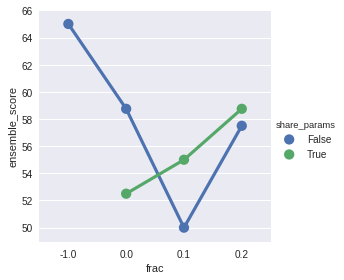

In [94]:
sns.factorplot(data=df,x='frac',y='ensemble_score',hue='share_params')

In [66]:
model

DataParallel(
  (module): DenseNet_partial(
    (conv1): Conv2D_partial(
    )
    (dense1): Sequential(
      (0): Bottleneck(
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2D_partial(
        )
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2D_partial(
        )
        (relu): ReLU(inplace)
      )
      (1): Bottleneck(
        (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2D_partial(
        )
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2D_partial(
        )
        (relu): ReLU(inplace)
      )
      (2): Bottleneck(
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2D_partial(
        )
        (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2D_partial(
        )
        (relu): ReLU(inplace)
      )
      (3): Bottleneck(
        (bn1): Ba

[46.25, 42.5, 45.625, 41.875, 48.125, 45.3125, 43.75, 42.8125, 44.375, 46.875]

n models 0: 46.25
n models 1: 49.375
n models 2: 50.0
n models 3: 50.0
n models 4: 49.375
n models 5: 50.0
n models 6: 49.375
n models 7: 46.875
n models 8: 46.875
n models 9: 47.8125
mean single models: 44.75
var single models: 3.74609375


In [24]:
float(sum(OO[0].argmax(1)==TT[0]))/len(TT[0])



0.4625

0

In [261]:
test(testloader,model,criterion,0,True)

(1.5632840013504028, 41.799999694824216)

PART: -1.0


In [264]:
checkpointPath

'/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_5_opt_sgd_subsample_1_only_train_nothing_ENS'

In [63]:
a = torch.load('/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_1_opt_sgd_subsample_1_only_train_nothing_ENS/model_best.pth.tar')
a = a['state_dict']
b = torch.load('/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_2_opt_sgd_subsample_1_only_train_nothing_ENS/model_best.pth.tar')
b = b['state_dict']
for k in a.keys():
    if 'fixed' in k:
        assert (a[k]-b[k]).abs().sum()==0

True

python cifar.py -a densenet_partial --depth 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 1 --checkpoint /home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_2_opt_sgd_subsample_1_only_train_nothing_ENS_V --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part 0 --schedule 150 225 --dataset cifar10


['/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_1_opt_sgd_subsample_1_only_train_nothing_ENS',
 '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_2_opt_sgd_subsample_1_only_train_nothing_ENS_V',
 '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_3_opt_sgd_subsample_1_only_train_nothing_ENS_V',
 '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_4_opt_sgd_subsample_1_only_train_nothing_ENS_V',
 '/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0_iter_5_opt_sgd_subsample_1_only_train_nothing_ENS_V']

In [7]:
import matplotlib.patches as patches

# Plot kill-fixed vs not kill fixed

In [8]:
df = pd.DataFrame(ddd)
d1 = df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False)]

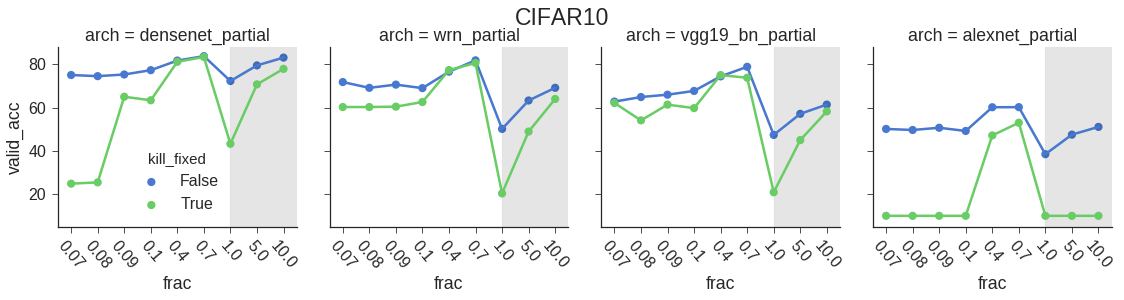

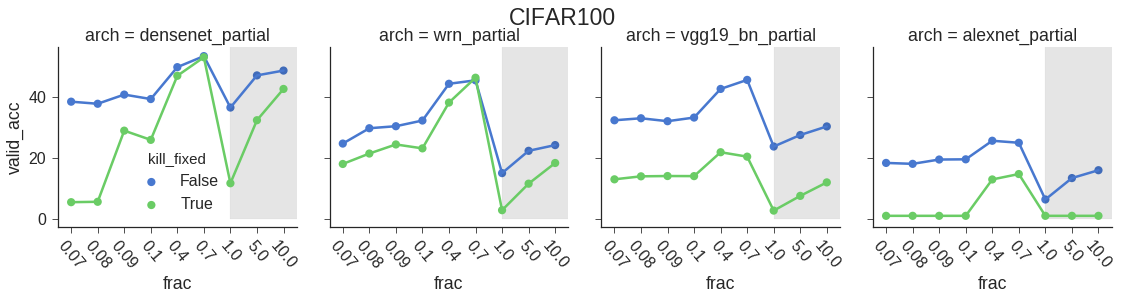

In [174]:



sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
for z in ['cifar10','cifar100']:
    df = pd.DataFrame(ddd)
    df['frac'] = df['frac'].round(2)
    
    df=df[df.arch!='vgg19_partial']
    #df=df[df.arch=='wrn_partial']
    #df=df[df.fast_schedule==True]
    df=df[df.dataset==z]
    df=df[df.optimizer=='sgd']
    #df['abs_filters']=df.frac>=1
    df.sort_values('frac')
    
    if LIMIT_EPOCHS != 1:    
        df = df[df.frac>0]
        df = df[df.learn_bn==True]
        #df = df[df.kill_fixed==False]  
        #theHue = 'learn_bn' # kill_fixed
        theHue = 'kill_fixed'
    else:
        df = df[df.frac>0]        
        df = df[df.kill_fixed==False]
        theHue = 'learn_bn'
        
        
    #sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
    g=sns.factorplot(data=df,x='frac',y='valid_acc',hue=theHue,col='arch',legend_out=False)
    g.set_xticklabels(rotation=-50)
    suptitle(z.upper(),y=1)    
    for ax in list(g.axes[0]):
        ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
        #df = pd.DataFrame(ddd)
        #z = df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False) &\
        #      (df.dataset==z)]
        #ax.plot([-1,9],2*[zs[iz]],color='k',linestyle='--')
        #iz+=1
    savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/{}_frac_vs_perf_{}_epochs.pdf'.format(z,LIMIT_EPOCHS))

# Plot kill-fixed vs not kill fixed - FULL RUN

In [75]:
pd.DataFrame(ddd).sort_values('valid_acc',ascending=False)

,active_params,all_accs,arch,dataset,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc
11,769162,0 61.34 1 72.35 2 70.23 3 78.73 4 ...,densenet_partial,cifar10,False,-1.00,True,True,sgd,769162,train_all,61.34
96,532894,0 60.78 1 68.81 2 73.80 3 ...,densenet_partial,cifar10,False,0.70,False,True,sgd,769162,train_all,60.78
68,305701,0 59.73 1 68.42 2 72.93 3 ...,densenet_partial,cifar10,False,0.40,False,True,sgd,769162,train_all,59.73
152,328528,0 59.09 1 71.12 2 71.00 3 78.27 4 ...,densenet_partial,cifar10,False,10.00,False,True,sgd,769162,train_all,59.09
9,769162,0 58.46 1 69.34 2 69.89 3 78.88 4 ...,densenet_partial,cifar10,False,-1.00,False,True,sgd,769162,train_all,58.46
10,745174,0 58.12 1 64.04 2 75.18 3 74.65 4 ...,densenet_partial,cifar10,False,-1.00,False,False,sgd,769162,train_all,58.12
97,508906,0 57.04 1 68.31 2 73.39 3 71.95 4 ...,densenet_partial,cifar10,False,0.70,False,False,sgd,769162,train_all,57.04
124,177973,0 56.54 1 65.61 2 69.88 3 71.02 4 ...,densenet_partial,cifar10,False,5.00,False,True,sgd,769162,train_all,56.54
69,281713,0 56.06 1 67.96 2 67.17 3 73.52 4 ...,densenet_partial,cifar10,False,0.40,False,False,sgd,769162,train_all,56.06
12,745174,0 54.20 1 62.80 2 71.72 3 74.27 4 ...,densenet_partial,cifar10,False,-1.00,True,False,sgd,769162,train_all,54.20


In [10]:
#df[(df.arch=='densenet_partial') & (df.dataset =='cifar100')].index

In [143]:
df['max_stuff']=0
df[df[(df.arch=='densenet_partial') & (df.dataset =='cifar100')]].max_stuff = 10
df

ValueError: Must pass DataFrame with boolean values only

In [ ]:
df = pd.DataFrame(ddd)
df.valid_acc/=96
df[df.dataset=='cifar10'].sort_values('valid_acc')

In [144]:
df = pd.DataFrame(ddd)
df = df[((df.frac==1) ) & (df.dataset=='cifar100')].sort_values('arch')
df['z']=100*(df.active_params/df.total_params)
df

,active_params,all_accs,arch,dataset,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc,z
204,35156,0 1.96 1 2.99 2 3.65 3 4.18 4 4...,alexnet_partial,cifar100,False,1.0,False,True,sgd,2495396,train_all,6.34,1.408835
205,35156,0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 5...,alexnet_partial,cifar100,False,1.0,True,True,sgd,2495396,train_all,1.00,1.408835
194,88399,0 15.27 1 21.04 2 25.08 3 27.73 4 ...,densenet_partial,cifar100,False,1.0,False,True,sgd,800032,train_all,36.39,11.049433
195,64411,0 12.16 1 15.46 2 18.42 3 20.03 4 ...,densenet_partial,cifar100,False,1.0,False,False,sgd,800032,train_all,23.38,8.051053
196,88399,0 5.98 1 6.42 2 7.78 3 9.36 4 ...,densenet_partial,cifar100,False,1.0,True,True,sgd,800032,train_all,11.65,11.049433
197,64411,0 2.36 1 3.49 2 3.37 3 4.84 4 5...,densenet_partial,cifar100,False,1.0,True,False,sgd,800032,train_all,7.39,8.051053
202,107279,0 11.73 1 14.16 2 15.77 3 17.86 4 ...,vgg19_bn_partial,cifar100,False,1.0,False,True,sgd,20086692,train_all,23.65,0.534080
203,107279,0 1.47 1 2.00 2 1.66 3 2.23 4 2...,vgg19_bn_partial,cifar100,False,1.0,True,True,sgd,20086692,train_all,2.71,0.534080
206,96271,0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 5...,vgg19_partial,cifar100,False,1.0,False,True,sgd,20075684,train_all,1.00,0.479540
207,96271,0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 5...,vgg19_partial,cifar100,False,1.0,True,True,sgd,20075684,train_all,1.00,0.479540


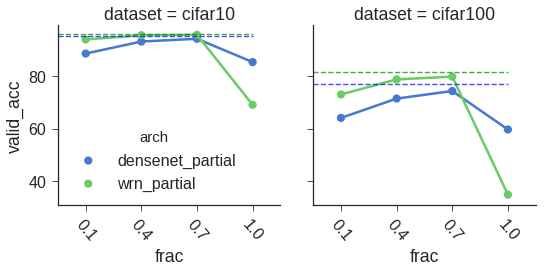

In [155]:
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)

df = pd.DataFrame(ddd)
df['frac'] = df['frac'].round(2)
df=df[df.arch!='vgg19_partial']
df=df[df.optimizer=='sgd']
#df['abs_filters']=df.frac>=1
df.sort_values('frac')
if LIMIT_EPOCHS != 1:    
    df = df[df.frac>0]
    df = df[df.learn_bn==True]
    #df = df[df.kill_fixed==False]  
    #theHue = 'learn_bn' # kill_fixed
    theHue = 'kill_fixed'
else:
    df = df[df.frac>0]        
    df = df[df.kill_fixed==False]
    theHue = 'learn_bn'        
#sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
g=sns.factorplot(data=df,x='frac',y='valid_acc',col='dataset',hue='arch',legend_out=False)
g.set_xticklabels(rotation=-50)
axes_ = list(g.axes[0])
theAlpha=.7
ZZ = 3
ZZ0 = -.5
axes_[0].plot([ZZ0,ZZ],2*[96.2],color='g',linestyle='--',alpha=theAlpha)
axes_[0].plot([ZZ0,ZZ],2*[100-4.54],color='blue',linestyle='--',alpha=theAlpha)

axes_[1].plot([ZZ0,ZZ],2*[100- 18.14],color='g',linestyle='--',alpha=theAlpha)
axes_[1].plot([ZZ0,ZZ],2*[100-22.88],color='blue',linestyle='--',alpha=theAlpha) #
#axes_[1].plot([-1,9],2*[96.2],color='g',linestyle='--')
#axes_[1].plot([-1,9],2*[100-4.54],color='r',linestyle='--')
#suptitle(z.upper(),y=1)    
#for ax in list(g.axes[0]):
#    ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
    #df = pd.DataFrame(ddd)
    #z = df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False) &\
    #      (df.dataset==z)]
    #ax.plot([-1,9],2*[zs[iz]],color='k',linestyle='--')
    #iz+=1
       
#savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/frac_vs_perf_full_run.pdf')

In [ ]:
import torch
from torch.autograd import Variable
model.features(Variable(torch.zeros(1,3,32,32))).shape

In [ ]:
from torch.nn import Conv2d
model.features[0] = Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))




In [ ]:
list(model.classifier)[:-1]

In [ ]:
s = 0
from torch import nn

for a,b in model.named_modules():
    if type(b) is nn.Conv2d:
        s+=countParams(b)
s

In [ ]:
countParams(model.classifier)

In [ ]:
from torchvision import models


    

In [ ]:
x

In [ ]:
df.frac

In [ ]:
df

In [ ]:
zip(df.active_params,df.total_params)

In [ ]:
#df.active_params / df.total_params,df.valid_acc

In [ ]:
df = pd.DataFrame(ddd)
df = df[df.frac !=-1 ]
df = df[df.dataset=='cifar10']
x = df.frac
y = df.valid_acc
#scatter(x,y)
#xticks( , ('0.1', '0.4', '0.7', '1', 'Sue') )
scatter(df.active_params / df.total_params,df.valid_acc,marker='+',color='r')





In [ ]:
df = pd.DataFrame(ddd)
df = df[(df.train_only=='train_all') & (df.dataset=='cifar10')]
df

In [ ]:
#36479194/10**6

# plot use bn vs not use bn

In [ ]:

df['frac'] = df['frac'].round(2)

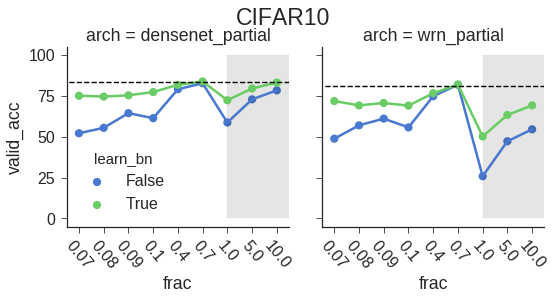

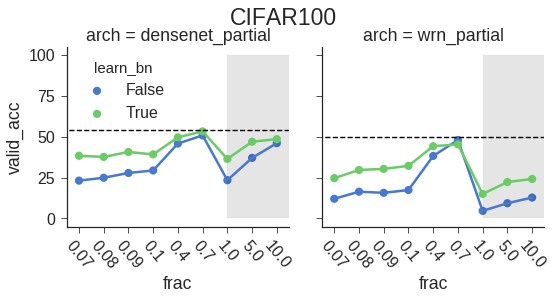

In [176]:
df = pd.DataFrame(ddd)
zs = df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False)].valid_acc
zs = list(zs)
iz = 0

sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
for z in ['cifar10','cifar100']:
    df = pd.DataFrame(ddd)
    df = df[df.arch.isin(['wrn_partial','wrn','densenet_partial','densenet'])]
    df['frac'] = df['frac'].round(2)
    df=df[df.dataset==z]
    df=df[df.optimizer=='sgd']
    df.sort_values('frac')
    df = df[df.frac>0]        
    df = df[df.kill_fixed==False]
    theHue = 'learn_bn'
    g=sns.factorplot(data=df,x='frac',y='valid_acc',hue=theHue,col='arch',legend_out=False)
    g.set_xticklabels(rotation=-50)
    suptitle(z.upper(),y=1)    
    for ax in list(g.axes[0]):
        ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
        
        ax.plot([-1,9],2*[zs[iz]],color='k',linestyle='--')
        iz+=1
    savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/{}_frac_vs_perf_{}_bn_epochs.pdf'.format(z,LIMIT_EPOCHS))

In [ ]:
df = pd.DataFrame(ddd)
df[(df.frac==-1) &(df.train_only=='train_all') & (df.learn_bn==True) & (df.kill_fixed==False)]

In [ ]:
import humanize
humanize.intword('435345')

In [ ]:
df = pd.DataFrame(ddd)
df = df[df.dataset=='cifar10']
df[(df.train_only=='train_all')&(df.frac==-1)]

In [ ]:
df[(df.train_only=='train_nothing') &(df.frac==-1)]

In [ ]:
df = pd.DataFrame(ddd)
df[(df.train_only=='train_nothing') &(df.frac==-1) & (df.dataset=='cifar10')]

In [ ]:
from ballpark import ballpark as B
df = pd.DataFrame(ddd)
df = df[df.train_only!='train_all']
df = df.drop(['all_accs','kill_fixed','optimizer','learn_bn','frac','fast_schedule'],axis=1)
df.active_params=df.active_params.apply(lambda x:B(x))
df.total_params=df.total_params.apply(lambda x:B(x))

df=df.rename(columns={'active_params':'active params','total_params':'total_params',
                   'train_only':'layer','valid_acc':'Top-1%'})
#df.sort_values('Top-1%')

print df[df.dataset=='cifar10'].drop('dataset',axis=1).to_latex()

In [ ]:
print df[df.dataset=='cifar100'].drop('dataset',axis=1).to_latex()
#print df.pivot_table(columns=['dataset','arch','layer']).to_latex()#,values=['Top-1%'])

In [ ]:
df.T

In [ ]:
df.sort_values('arch')

In [ ]:
pd.DataFrame(ddd).train_only.unique()

In [ ]:
df = pd.DataFrame(ddd)
df = df[df.frac==-1]


In [ ]:
df = pd.DataFrame(ddd)
df = df[df.frac==-1]
#df = df[df.dataset=='cifar10']
#df['valid_acc_max']=df.groupby(['train_only'])['valid_acc'].idxmax()

#df.loc[df.groupby(['train_only','dataset'])["valid_acc"].idxmax()].sort_values(['train_only'])
df = df[df.dataset=='cifar10']
df = df[df.arch=='wrn_partial']
df
#df.sort_values('valid_acc')


In [ ]:
df = pd.DataFrame(ddd)
df[df.arch=='densenet_partial']

In [ ]:
df = pd.DataFrame(ddd)
df

In [ ]:
df = pd.DataFrame(ddd)
df = df[df.kill_fixed==True]
df = df[df.dataset=='cifar10']


df = df[df.frac < .2]
#df = df[df.frac==.4]
#df = df[df.frac>.08]
df.active_params/=10.**6
df 
#df[['active_params','arch','kill_fixed','valid_acc','frac']].sort_values(['valid_acc','frac'])


In [ ]:
14606284/10**6

In [ ]:
#3669829/10**6

In [ ]:
opts_with_state[0].

In [ ]:
#df.sort_values('valid_acc',ascending=False)

In [ ]:
kf = df.kill_fixed
aa = df.arch
z = []
for a,b in zip(aa,kf):
    if b:
        z.append(a+'_zero')
    else:
        z.append(a+'_fix')
df['arch'] = z


In [ ]:
from copy import deepcopy
df = pd.DataFrame(ddd)



In [ ]:
df1 = deepcopy(df)


In [ ]:
df = pd.DataFrame(ddd)
df=df.rename(columns={'valid_acc':'% Accuracy','frac':'fraction'})

df[(df['fraction'] > 0) & (df['fraction'] < 1)

In [ ]:
set(df.fraction.round(2))

In [ ]:
close()
df = pd.DataFrame(ddd)
df = df[df.arch!='vgg19_partial']
kf = df.kill_fixed
aa = df.arch
z = []
for a,b in zip(aa,kf):
    if b:
        z.append(a+'_zero')
    else:
        z.append(a+'_fix')
df['arch'] = z
import matplotlib.patches as patches

mm='Fraction Conv. Params'
acc_name = '% Accuracy'
df=df.rename(columns={'valid_acc':acc_name,'frac':mm})

df = df[::-1]
df[mm] = df[mm].round(2)


sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
sns.set_palette('muted')
for z in ['cifar10','cifar100']:
    isFractional=(df[mm] > 0)# & (df[mm] < 1)
    isDataSet=(df['dataset'] == z)        
    kwargs = dict(data=df[isFractional & isDataSet],x=mm,y='% Accuracy',hue='arch',col='dataset',palette=sns.color_palette('Paired',n_colors=8, desat=1),
                      aspect=1.5)
    if z == 'cifar100':
        kwargs['legend']=None
    sns.factorplot(**kwargs)    
    ax = gca()    
    ax.plot(x=[5.9,5.9,],y=[0,100],color=[255,255,255],linewidth=10)
    #ax.scatter(5.9,100,marker='+')        
    #ax.plot([6-eps,6-eps],[10,100],color='k',linewidth=5,alpha=.1,linestyle='-')
    ax.add_patch(patches.Rectangle(xy=(6, 0), width=4, height=100,alpha=.1,color='k'))
    plt.savefig('/home/amir/publications/iclr_workshop/figures/fractional_{}.pdf'.format(z))

In [ ]:
archs

In [ ]:
colors=sns.color_palette('muted',len(archs))

In [ ]:
df = pd.DataFrame(ddd)

In [ ]:
z

Populating the interactive namespace from numpy and matplotlib


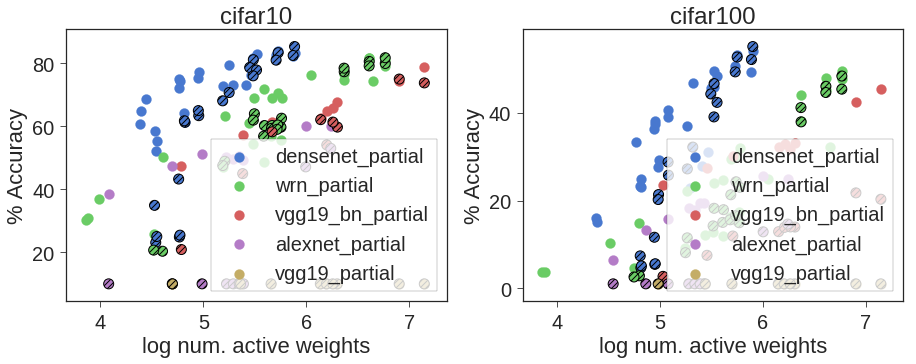

In [49]:
close()
%pylab inline
import seaborn as sns
sns.set_context('paper',font_scale=2.5)
sns.set_style('ticks')
df = pd.DataFrame(ddd)
if False:
    kf = df.kill_fixed
    aa = df.arch
    z = []
    for a,b in zip(aa,kf):
        if b:
            z.append(a+'_zero')
        else:
            z.append(a+'_fix')
    df['arch'] = z
ss=100
figure(figsize=(15,5))
mmmm=1
nnnn=2
colors=sns.color_palette('muted',len(archs))
for ii,zz in enumerate(['cifar10','cifar100']):
    
    subplot(mmmm,nnnn,ii+1);title(zz)
    for i,z in enumerate(archs):        
        df1=df[df.dataset==zz]
        df1 = df1[df1.arch==z]
        p = False;            
        df1 = df1[df1.kill_fixed==p]
        kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], label=z, color=colors[i],s=ss)#, marker=theMarker)
        scatter(**kwargs)
        xlabel('log num. active weights')
        ylabel('% Accuracy')
    if True:#ii == 1:
        leg=legend(loc='lower right',frameon=True,fancybox=False)
        leg.get_frame().set_edgecolor('k')
        
        
#font = {'size'   : 50}

matplotlib.rc('font', **font)
        
if True:
    for ii,zz in enumerate(['cifar10','cifar100']):

        subplot(mmmm,nnnn,ii+1);title(zz)
        for i,z in enumerate(archs):        
            df1=df[df.dataset==zz]
            df1 = df1[df1.arch==z]

            #plot(range(10,range(10)))
            p = True;
            #for p in [False,True]:
            df1 = df1[df1.kill_fixed==p]
            
            #theMarker = '*'
            #marker=theMarker
            kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], color=colors[i],s=ss,edgecolor='k',linewidth=1, hatch='////')
            scatter(**kwargs)
            matplotlib.rcParams.update({'font.size': 22})
        #if ii == 1:
        #    ax = gca()
        #    ax.set_ylabel('')
           



#savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/perf_vs_params2.pdf',bbox_inches='tight')
#f = leg.get_frame()
    

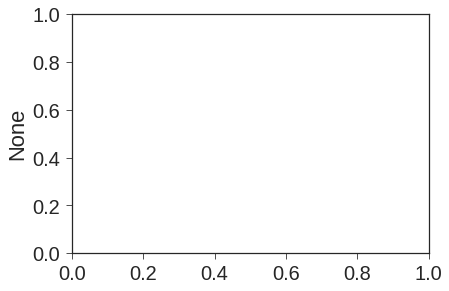

Populating the interactive namespace from numpy and matplotlib


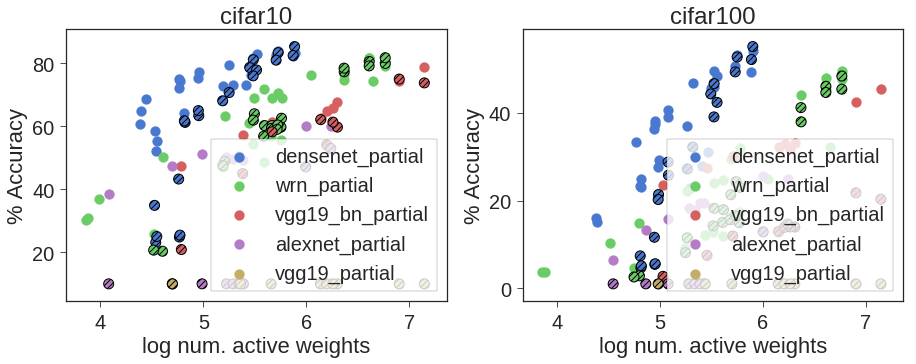

In [54]:
close()
%pylab inline
df = pd.DataFrame(ddd)
if False:
    kf = df.kill_fixed
    aa = df.arch
    z = []
    for a,b in zip(aa,kf):
        if b:
            z.append(a+'_zero')
        else:
            z.append(a+'_fix')
    df['arch'] = z
ss=100
figure(figsize=(15,5))
mmmm=1
nnnn=2
colors=sns.color_palette('muted',len(archs))
for ii,zz in enumerate(['cifar10','cifar100']):
    
    subplot(mmmm,nnnn,ii+1);title(zz)
    for i,z in enumerate(archs):        
        df1=df[df.dataset==zz]
        
        df1 = df1[df1.arch==z]
        p = False;            
        df1 = df1[df1.kill_fixed==p]
        kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], label=z, color=colors[i],s=ss)#, marker=theMarker)
        scatter(**kwargs)
        xlabel('log num. active weights')
        ylabel('% Accuracy')
    if True:#ii == 1:
        leg=legend(loc='lower right',frameon=True,fancybox=False)
        leg.get_frame().set_edgecolor('k')
if True:
    for ii,zz in enumerate(['cifar10','cifar100']):

        subplot(mmmm,nnnn,ii+1);title(zz)
        for i,z in enumerate(archs):        
            df1=df[df.dataset==zz]
            df1 = df1[df1.arch==z]

            #plot(range(10,range(10)))
            p = True;
            #for p in [False,True]:
            df1 = df1[df1.kill_fixed==p]
            
            #theMarker = '*'
            #marker=theMarker
            kwargs = dict(x=log10(df1.active_params), y=df1['valid_acc'], color=colors[i],s=ss,edgecolor='k',linewidth=1, hatch='////')
            scatter(**kwargs)            




savefig('/home/amir/publications/iclr_workshop/figures/perf_vs_params.pdf',bbox_inches='tight')
#f = leg.get_frame()


In [ ]:
df

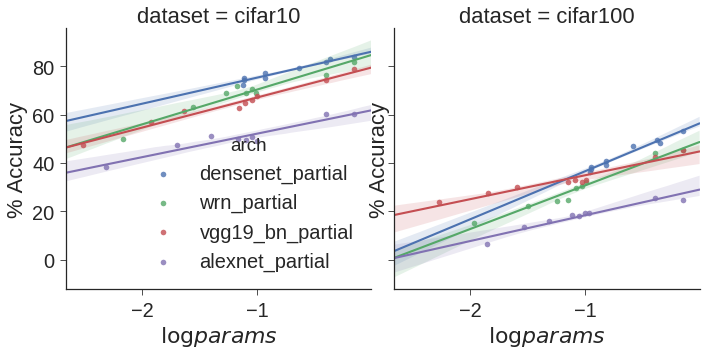

In [56]:
df = pd.DataFrame(ddd)


df = df[df.train_only=='train_all']
df = df[df.learn_bn==True]
df = df[df.frac>0]
df.active_params/=df.total_params
df = df[df.kill_fixed==False]
df = df[df.kill_fixed==False]
df = df[df.arch!='vgg19_partial']
df.active_params = log10(df.active_params)#**.5
#df.valid_acc = df.valid_acc.apply(lambda x: log10(x)) #= log10(df.valid_acc)
#df = df[df.arch!='vgg19_bn_partial']
#df = df[df.arch!='alexnet_partial']
g = sns.lmplot(data=df,x='active_params',y='valid_acc',hue='arch',col='dataset',logx=False,legend_out=False)
for gg in g.axes[0]:
    gg.set_xlabel('$\log{params}$')
    gg.set_ylabel('% Accuracy')    
savefig('/home/amir/publications/icml2018_style/figures/perf_vs_params_lines2.pdf')#,bbox_inches='tight')

In [ ]:
r=g.axes[0][0]
r.set_xlabel('$')

In [ ]:
close()
df = pd.DataFrame(ddd)

kf = df.kill_fixed
aa = df.arch
z = []
for a,b in zip(aa,kf):
    if b:
        z.append(a+'_zero')
    else:
        z.append(a+'_fix')
df['arch'] = z

mm='Fraction Conv. Params'
df=df.rename(columns={'valid_acc':'% Accuracy','frac':mm})

df = df[::-1]
df[mm] = df[mm].round(2)
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
sns.set_palette('muted')
for z in ['cifar10','cifar100']:
    sel_=(df[mm] >= 1)
    isDataSet=(df['dataset'] == z)        
    kwargs = dict(data=df[sel_ & isDataSet],x=mm,y='% Accuracy',hue='arch',col='dataset',palette=sns.color_palette('Paired',n_colors=12, desat=1),
                      aspect=1.5)
    if z == 'cifar100':
        kwargs['legend']=None
    sns.factorplot(**kwargs)    

In [ ]:
pd.__version__


In [ ]:
df['dataset']==z

In [ ]:
#set((df.dataset=='cifar100'))

In [ ]:
df=deepcopy(df1)
df=df[df.dataset==z]
df=df[df.optimizer=='sgd']    W
sns.factorplot(data=df,x='frac',y='valid_acc',hue='arch')

In [ ]:
df = pd.DataFrame(ddd)
df = df[df.dataset=='cifar10']
df = df[df.arch=='densenet_partial']
scatter(log10(df.active_params),df.valid_acc)

In [ ]:
df = pd.DataFrame(ddd)
df1=df[df.train_only!='train_all']

In [ ]:
df1[(df1.train_only=='conv1') & (df1.dataset=='cifar10') & (df1.arch=='wrn_partial')]

In [ ]:
sns.factorplot(data=df1,x='train_only',y='valid_acc',hue='arch',col='dataset')

In [ ]:
df = pd.DataFrame(ddd)
df[df.train_only!='train_all'].groupby('train_only').max()

In [ ]:
import torch
a = torch.load('/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/densenet-bc-100-12_0.1_iter_0_opt_sgd_subsample_1/model_best.pth.tar')
a.keys()
s = a['state_dict']

In [ ]:
%qtconsole

In [ ]:
df = pd.DataFrame(ddd)
df

In [ ]:
df1=pd.DataFrame(opts_with_state)
len(df1)
len(df1[df1.message!='found.'])

In [ ]:
df = pd.DataFrame(ddd)
df.active_params=around(df.active_params)

df[df.frac==-1].groupby(['dataset','arch','train_only']).max()

In [ ]:
df.sort_values('valid_acc',ascending=False)

In [ ]:
if False:
    import glob
    g = glob.glob('/home/amir/checkpoints/cifar10/*')
    import shutil
    for p in g:
        if 'LIMIT_EPOCHS' in g:
            continue
        if p == '/home/amir/checkpoints/cifar10/cifar10':
            continue
        limit_epoch_dir = p.replace('/cifar10','/cifar10/LIMIT_EPOCHS')
        if not os.path.isdir(limit_epoch_dir):        

            print 'aha'
            os.mkdir(limit_epoch_dir)
            for f in glob.glob(os.path.join(p,'*.txt')):
                shutil.copy(f,limit_epoch_dir)

In [ ]:
paramCountPath

In [ ]:
pd.DataFrame(ddd).sort_values('frac')

In [ ]:
# Let's also spew out the number of active parameters. 

In [ ]:
df1=pd.DataFrame(opts_with_state)
df1[df1.message != 'found.'].sort_values('dataset')

In [ ]:
pd.DataFrame(opts_with_state)

In [ ]:
df1=pd.DataFrame(opts_with_state)

In [ ]:
df.sort_values('valid_acc')

In [ ]:
df = pd.DataFrame(ddd)
prms=df.active_params/df.total_params
scores = df.valid_acc
ff = df.kill_fixed
scatter(prms[ff],scores[ff],color='r')
scatter(prms[~ff],scores[~ff],color='b')

In [ ]:
df1=pd.DataFrame(opts_with_state).sort_values(['arch','dataset'])
df1[(df1.dataset=='cifar10') & (df1.message !='found.') & (df1.arch =='wrn_partial')]

In [ ]:
if True:
    limit_epochs_dirs = glob('/home/amir/checkpoints/cifar10/LIMIT_EPOCHS/*')
    for k in limit_epochs_dirs:
        f = os.path.join(k,'log.txt')

        no_limit_dir = k.replace('LIMIT_EPOCHS/','')

        if os.path.isfile(f):
            nLines = len(open(f).readlines())
        f1 = f.replace('LIMIT_EPOCHS/','')
        if os.path.isfile(f1):
            #print 'found file in non-epoch limited directory!'
            nLines1 = len(open(f1).readlines())

            #print nLines,'-->',nLines1
            if nLines1 == 60:
                print f1
                print no_limit_dir
        else:
            #print 'didn\'t find in non-limit dir, but got',nLines            
            if nLines > 11:
                print 'moving to orig dir...'
            #    shutil.move(k,no_limit_dir)
    #break


In [ ]:
print k
print no_limit_dir

In [ ]:
no_limit_dir

In [ ]:
pd.DataFrame(ddd)

In [ ]:
import shutil

In [ ]:
if False:
    import shutil
    d1 = []
    d2 = []
    for k in opts_with_state:
        logFilePath = k['logFilePath']
        curDir = ('/'.join(logFilePath.split('/')[:-1]))
        newDir = curDir.replace('/cifar10/','/cifar10/LIMIT_EPOCHS/')
        d1.append(curDir)
        d2.append(newDir)

    #shutil.move(curDir,newDir)
    #shutil.move(curDir,) 

In [ ]:
for k in opts_with_state:
    
    

In [ ]:
pd.DataFrame(opts_with_state).sort_values('message',ascending=False)

In [ ]:
from glob import glob
dfs = {}
df = pd.DataFrame(ddd)
df.sort_values('frac')
len(df)

In [ ]:
import seaborn as sns
for z in ['cifar10','cifar100']:
    df = pd.DataFrame(ddd)
    #df=df[df.arch=='wrn_partial']
    #df=df[df.fast_schedule==True]
    df=df[df.dataset==z]
    df=df[df.optimizer=='sgd']
    #df['abs_filters']=df.frac>=1
    df.sort_values('frac')
    #sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
    sns.factorplot(data=df,x='frac',y='valid_acc',hue='kill_fixed',col='arch')
    suptitle(z)

In [ ]:

from glob import glob
dfs = {}
ddd = []
#for frac in arange(0,1.01,.1):
finerRange = list(arange(0,.1,.01)[1:])
coarseRange = list(arange(0,1.01,.1))
kill_fixed=True
my_optimizer='adam'
for frac in coarseRange+finerRange:#+absoluteRange:
    
    #checkpointPath = '/home/amir/checkpoints/cifar10/WRN-28-10-frac_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.format(bb=frac,iter_=iter_,opt=my_optimizer,s=subsample)
    #checkpointPath = '/home/amir/checkpoints/cifar10/WRN-28-10-frac_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.format(bb=frac,iter_=iter_,opt=my_optimizer,s=subsample)
    
    if frac * 16 < 1: # check if there are no non-zero parameters in the first layer.
            #print('continuing on frac:',frac)
            continue
    epochs = 200
    if my_optimizer.lower()=='adam':
        epochs=10
    if frac == 0 and kill_fixed:
        epochs = 1

    checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                             kill_fixed)
    
   # if kill_fixed:
   #     checkpointPath += '_zero_fixed'
    logFile = checkpointPath+'/log.txt'
    try:
        dfs[frac] =pd.read_table(logFile)
        curValidAcc = dfs[frac]['Valid Acc.'].max()
        scatter(frac,curValidAcc,label=str(frac))
        print(dfs[frac]['Valid Acc.'].max())
        ddd.append((frac,curValidAcc))
        #scatter(frac,dfs[frac]['Valid Loss'].min(),label=str(frac))
    except:
        pass
#legend(loc='best')

In [ ]:
dfs[frac][:10]['Train Acc.'].tolist()

In [ ]:
dfs[.01]['Vald']

In [ ]:
from collections import OrderedDict
aa = []
for frac in finerRange+coarseRange:
    a = asarray(dfs[frac]['Valid Acc.'])
    t = trapz(a/max(a))
    scatter(frac,t)
    aa.append((frac,t))

In [ ]:
pd.DataFrame(aa,columns=['frac','p']).sort_values('frac').plot(x='frac',y='p')

In [ ]:
for frac in finerRange+coarseRange:
    plot(dfs[frac]['Valid Acc.'].tolist(),label=frac)
legend()

In [ ]:
zip(ds,vs)

In [ ]:
ds,vs = zip(*ddd)
ds,vs = array(ds),array(vs)
a = argsort(ds)
plot(ds[a],vs[a],'r-o',markersize=4,color='blue')

In [ ]:
from glob import glob
dfs = {}
my_optimizer='sgd'
subsample=1
iter_=0
finerRange=arange(0,.1,.01)[1:]
for frac in list(finerRange)+list(arange(0,1.01,.1)):
#for frac in arange(0,1.01,.1):
    checkpointPath = '/home/amir/checkpoints/cifar10/WRN-28-10-frac_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.format(bb=frac,iter_=iter_,opt=my_optimizer,s=subsample)
    #checkpointPath = '/home/amir/checkpoints/cifar10/WRN-28-10-frac_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.format(bb=frac,iter_=iter_,opt=my_optimizer,s=subsample)
    logFile = checkpointPath+'/log.txt'
    try:
        dfs[frac] =pd.read_table(logFile)
        plot(dfs[frac]['Valid Acc.'],label=str(frac))
    except:
        pass
legend(loc='best')

In [ ]:
cd ~/code/pytorch-classification/

In [ ]:
m2

In [6]:
models.wrn()

AttributeError: 'module' object has no attribute 'wrn'

In [ ]:
#humanize.intword(100000000)

In [2]:
cd ~/code/pytorch-classification/

/home/amir/Dropbox/code/pytorch-classification


In [3]:
import models.imagenet as models
from torch.autograd import Variable
import torch
m=models.resnext50_partial(1,64,0.1,False,True);

INITIALIZNG !!!!!
----------------- True -----------
INITIALIZNG !!!!!
*****~~~~~~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
<><><><>
*****~?????~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
*****~$#@@$%@~***** True
*****~?????~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
*****~$#@@$%@~***** True
INITIALIZNG !!!!!
*****~~~~~~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
<><><><>
*****~?????~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
*****~$#@@$%@~***** True
*****~?????~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
*****~$#@@$%@~***** True
*****~?????~***** True
-----------------> True
INITIALIZNG !!!!!
INITIALIZNG !!!!!
INITIALIZNG !!!!!
*****~$#@@$%@~***** True
INITIALIZNG !!!!!
*****~~~~~~***** True
-----------------> True

In [7]:
x = Variable(torch.zeros(1,3,32,32))
self=m
x = self.conv1(x)
x = self.bn1(x)
x = self.relu(x)
x = self.maxpool1(x)
x = self.layer1(x)
x = self.layer2(x)
x = self.layer3(x)
print x.shape
x = self.layer4(x)
print x.shape
x = self.avgpool(x)
print x.shape
x = x.view(x.size(0), -1)
#x = self.fc(x)

torch.Size([1, 1024, 2, 2])
torch.Size([1, 2048, 2, 2])
torch.Size([1, 2048, 1, 1])


In [6]:
m.fc

Linear(in_features=2048, out_features=1000, bias=True)

RuntimeError: size mismatch, m1: [1 x 8192], m2: [2048 x 1000] at /home/amir/pytorch/aten/src/TH/generic/THTensorMath.c:1431

In [12]:
import humanize
#n_params = 
import models.cifar as models
n_batch_params = 0
model = models.wrn_partial(depth=28,widen_factor=10,part=0,num_classes=100)
for m1,m2 in model.named_modules():
    if 'bn' in m1:
        
        n_batch_params+=sum([p.numel() for p in m2.parameters()])       
print 'number of batchnorm params:',n_batch_params
print 'number of fc params:',sum(p.numel() for p in model.fc.parameters())
z=sum(p.numel() for p in model.parameters() if p.requires_grad)
print 'total params:',humanize.intword(sum(p.numel() for p in model.parameters() if p.requires_grad))

ImportError: No module named models.cifar

# Slicing a filter along different dimensions.


In [167]:
import os
%pylab inline
import pandas as pd
# Let's try to train a fraction of the parameters.
#import os
homedir = os.path.expanduser('~')
subsample=1
TEST_subsample=1
my_optimizer='sgd'
epochs = 200
checkpointPaths = []
archs = ['densenet_partial']
datasets = ['cifar10']
#archs = ['wrn_partial']


pp=0
verbose=False
from itertools import product
fast_schedule = False
status = []

def make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,kill_fixed,dataset='cifar10',train_only='train_all',
                        learn_bn=True,dim_slice=0):
    P = arch_to_name_prefix[arch]
    checkpointPath = os.path.join(ckpt_base_dir,
                                  '{f_arch}_{bb}_iter_{iter_}_opt_{opt}_subsample_{s}'.
                                  format(f_arch=P,bb=frac,iter_=iter_,opt=my_optimizer,s=subsample))
    if kill_fixed:
        checkpointPath += '_zero_fixed'
        
    #if frac >= 1:# a fixed integer amount of filters.
    #    checkpointPath += '_I'
    if dataset != 'cifar10':
        checkpointPath += '_C100'
        
    if fast_schedule:
        checkpointPath += '_FS'        
        
    if train_only!='train_all':
        checkpointPath += '_only_{}'.format(train_only)
    if not learn_bn:
        checkpointPath += '_no-bn'
    checkpointPath += '_DS_{}'.format(dim_slice)
    return checkpointPath
optimizers = ['sgd']

iters = [0]
fracs =  [.1,1]

resnetWidth = 4
LIMIT_EPOCHS = 10
LIMIT_EPOCHS = -1
learn_bns = [True]
train_onlys = ['conv1','block1','block2','block3','fc','train_all']
dim_slices = [0,1,2,3]

if LIMIT_EPOCHS < 0:    
    fracs = [0.1,0.4,0.7,-1,1]
    resnetWidth=10
    archs = ['densenet_partial','wrn_partial']
    kill_fixed_s = [False]
    #archs = ['densenet_partial']
    train_onlys = ['train_all']
    learn_bns = [True]
else:
    #fracs = #[-1] + [0] + fracs
    fracs = [.1,.2,.4,.7,1,5]
    learn_bns = [True]
    train_onlys=['train_all']
    kill_fixed_s = [False,True]

all_opts = list(product(fracs,datasets,optimizers,archs,kill_fixed_s,iters,train_onlys,learn_bns,dim_slices))
opts_with_state=[]
ddd = []
dfs = {}

DDD = '/home/amir/checkpoints/cifar10/'
ckpt_base_dir = DDD
arch_to_name_prefix = {'squeezenet1_1_partial':'SQZ-frac',\
    'vgg19_partial':'VGG-frac',\
                       'vgg19_bn_partial':'VGG-BN-frac',\
                       'alexnet_partial':'ALEXNET-frac','wrn_partial':'WRN-28-{}-frac'.format(resnetWidth),'densenet_partial':'densenet-bc-100-12'}
arch_to_params = {'alexnet_partial':dict(epochs=164,lr_sched='81 122'),
                  'squeezenet1_1_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_partial':dict(epochs=164,lr_sched='81 122'),
                  'vgg19_bn_partial':dict(epochs=164,lr_sched='81 122'),
                  'wrn_partial':dict(epochs=200,lr_sched='60 120 160'),
                  'densenet_partial':dict(epochs=300,lr_sched='150 225')}
import matplotlib.patches as patches
PRINT_CMD=True
covered_paths = {}



for frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only,learn_bn,dim_slice in all_opts:
    arch_= arch
       
    #if frac >.1:
    #    if dim_slice not in [0,1]:
    #        continue
    n_epochs = arch_to_params[arch]['epochs']

    if fast_schedule:
        n_epochs=10

    if LIMIT_EPOCHS > 0:
        n_epochs = min(LIMIT_EPOCHS,n_epochs)            
        ckpt_base_dir = DDD + 'LIMIT_EPOCHS'
    if frac > 0 and frac * 16 < 1: # check if there are no non-zero parameters in the first layer.
        #print('continuing on frac:',frac)
        continue
    
    epochs = n_epochs
    if my_optimizer.lower()=='adam':
        epochs=10
    if frac == 0 and kill_fixed:
        epochs = 1

    checkpointPath = make_checkpoint_path(ckpt_base_dir,arch,frac,iter_,my_optimizer,subsample,
                                         kill_fixed,dataset,to_train_only,learn_bn,dim_slice)                        

    checkpointPaths.append(checkpointPath)

    if 'wrn' in arch:
        cmd = 'python cifar.py -a {arch} --depth 28 --widen-factor {resnetWidth} --train-batch 128 --drop 0.3 --wd 5e-4 --gamma 0.2 --epochs {epochs}'.\
        format(resnetWidth=resnetWidth,arch=arch_,epochs=epochs)
    elif 'dense' in arch:                
        cmd = 'python cifar.py -a {arch} --depthi 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs)
    elif 'alexnet' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'vgg' in arch:
        cmd = 'python cifar.py -a {arch} --wd 1e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    elif 'squeeze' in arch:
        cmd = 'python cifar.py -a {arch} --lr 0.04 --wd 2e-4 --gamma 0.1 --epochs {epochs}'.format(arch=arch_,epochs=epochs) 
    cmd += ' --checkpoint {checkpoint}'
    #cmd += ' --only-layer {retrain_layer}'

    lr=.1 if my_optimizer == 'sgd' else 1e-3

    cmd = cmd.format(checkpoint = checkpointPath)#,retrain_layer=retrain_layer)
    cmd += ' --start-epoch 0'
    cmd += ' --learn-bn {}'.format(learn_bn)        
    cmd += ' --lr {}'.format(lr)
    cmd += ' --optimizer {}'.format(my_optimizer)
    cmd += ' --subsample {}'.format(subsample)
    cmd += ' --test-subsample {}'.format(TEST_subsample)
    cmd += ' --zero-fixed-part {}'.format(kill_fixed)
    cmd += ' --part {frac}'.format(frac=frac)            
    if fast_schedule:
        cmd += ' --schedule 4 4'
    else:
        cmd += ' --schedule {}'.format(arch_to_params[arch]['lr_sched'])


    cmd += ' --dataset {}'.format(dataset)
    
    cmd += ' --dim-slice {}'.format(dim_slice)

    if frac == -1 and to_train_only != 'train_all':
         cmd += ' --only-layer {}'.format(to_train_only)
    #cmd += ' --schedule 10 20'

    logFilePath = os.path.join(checkpointPath,'log.txt')
    if logFilePath in covered_paths:
        continue
    else:
        covered_paths[logFilePath]=1
    paramCountPath = os.path.join(checkpointPath,'n_params.txt')
    #frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only 
    curOpts = dict(my_optimizer=my_optimizer,arch=arch,dataset=dataset,kill_fixed=kill_fixed,frac=frac,logFilePath=logFilePath,
                  train_only=to_train_only,learn_bn=learn_bn,dim_slice=dim_slice)
    
  
    if os.path.isfile(logFilePath):
        logData = open(logFilePath).readlines()

        try:
            n_params = open(paramCountPath).readlines()
            n_params = [int(p.strip().split()[-1]) for p in n_params]
        except:
        
            n_params = [-1 -1]
            
        nRows = len(logData)
        if nRows < epochs + 1:
            curOpts['ok']=False
            curOpts['message']='not enough rows'
            if verbose:
                print 'found log file but number of rows was',nRows
                print checkpointPath                    
        elif nRows >= epochs+1:
            curOpts['ok'] = True
            curOpts['message'] = 'found.'                
            try:

                dfs[frac] = pd.read_table(logFilePath)
                curValidAcc = dfs[frac]['Valid Acc.'][:epochs].max()                   
                ddd.append(dict(frac=frac,arch=arch,dataset=dataset,fast_schedule=fast_schedule,kill_fixed=kill_fixed,
                                optimizer=my_optimizer,valid_acc=curValidAcc,all_accs=dfs[frac]['Valid Acc.'],train_only=to_train_only,
                                active_params = n_params[0],total_params=n_params[1],learn_bn=learn_bn,dim_slice=dim_slice))

            except e:
                #raise(e)
                print 'FAILED LOADING',logFilePath                
                pass        
    else:
        curOpts['ok']=False
        curOpts['message']='file not found'
        if verbose:
            print 'could not find log file for {},{},{},{},{},{}'.format(my_optimizer,arch,dataset,kill_fixed,frac_,iter_)
            print 'directory:',checkpointPath
            #break
    if not curOpts['ok']:            
        # not ok, needs to be computed. 
        PRINT_CMD=True
        if PRINT_CMD: print(cmd)
        #pass
    opts_with_state.append(curOpts)

    pp+=1

print
print
import seaborn as sns
#sns.set_style('ticks')
#sns.set_context('paper',font_scale=1.5)
rn = {'valid_acc':'% Accuracy','kill_fixed':'zero_fixed'}
print 
print

Populating the interactive namespace from numpy and matplotlib
python cifar.py -a densenet_partial --depthi 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/cifar10/densenet-bc-100-12_0.1_iter_0_opt_sgd_subsample_1_DS_0 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part 0.1 --schedule 150 225 --dataset cifar10 --dim-slice 0
python cifar.py -a densenet_partial --depthi 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/cifar10/densenet-bc-100-12_0.1_iter_0_opt_sgd_subsample_1_DS_1 --start-epoch 0 --learn-bn True --lr 0.1 --optimizer sgd --subsample 1 --test-subsample 1 --zero-fixed-part False --part 0.1 --schedule 150 225 --dataset cifar10 --dim-slice 1
python cifar.py -a densenet_partial --depthi 100 --growthRate 12 --train-batch 64 --wd 1e-4 --gamma 0.1 --epochs 300 --checkpoint /home/amir/checkpoints/

In [68]:
df.valid_acc.max()

59.64

In [166]:
df = pd.DataFrame(ddd)
df[(df.dim_slice==3) & (df.kill_fixed==False)]

AttributeError: 'DataFrame' object has no attribute 'dim_slice'

In [163]:
df = pd.DataFrame(ddd)
df.dim_slice+=1
df.active_params=10*(10*(df.active_params/df.total_params)).round(0).map(int)
g=sns.factorplot(data=df[(df.kill_fixed==False) ],x='active_params',y='valid_acc',hue='dim_slice',kind='strip',aspect=1.5,s=10)
g.set_xticklabels(rotation=0)
xlabel('% learned parameters')
#savefig('/home/amir/publications/icml2018_style/figures/dim_slice_total.pdf')

AttributeError: 'DataFrame' object has no attribute 'dim_slice'

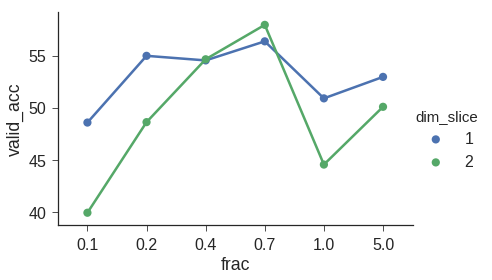

In [160]:
df = pd.DataFrame(ddd)
df.dim_slice+=1
sns.factorplot(data=df[(df.kill_fixed==False) & (df.dim_slice<=2)],x='frac',y='valid_acc',hue='dim_slice',aspect=1.5)
savefig('/home/amir/publications/icml2018_style/figures/dim_slice_relative.pdf')

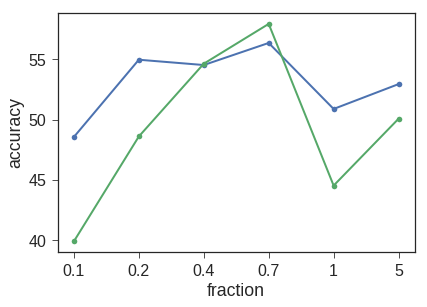

In [57]:
close()
# assing place to location

from collections import OrderedDict
dd=OrderedDict([(r,i) for i,r in enumerate([0.1,.2,.4,.7,1,5])])
import seaborn as sns
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')

df = pd.DataFrame(ddd)
for dim_slice in range(2):
    df1 = df[df.dim_slice==dim_slice]
    df1 = df1[df1.kill_fixed==False]
    xs = df1.frac
    y1 = df1.valid_acc
    plot([dd[q] for q in xs],df1.valid_acc,linewidth=2,marker='o')
    
    xlabel('fraction')
    ylabel('accuracy')
    #break
    #plot(range(),df1.valid_acc)
    #xticks(range(5),['0.1','0.4','0.7','1','5'])
xticks(range(len(dd.keys())),dd.keys());

In [140]:
df.sort_values('frac')

,active_params,all_accs,arch,dataset,dim_slice,fast_schedule,frac,kill_fixed,learn_bn,optimizer,total_params,train_only,valid_acc
0,90196,"0 48.57 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,0,False,0.1,False,True,sgd,769162,train_all,48.57
1,96610,"0 39.92 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,1,False,0.1,False,True,sgd,769162,train_all,39.92
2,602842,"0 59.63 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,2,False,0.1,False,True,sgd,769162,train_all,59.63
3,602842,"0 56.07 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,3,False,0.1,False,True,sgd,769162,train_all,56.07
4,90196,"0 42.96 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,0,False,0.1,True,True,sgd,769162,train_all,42.96
5,96610,"0 13.52 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,1,False,0.1,True,True,sgd,769162,train_all,13.52
6,602842,"0 53.91 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,2,False,0.1,True,True,sgd,769162,train_all,53.91
7,602842,"0 51.14 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,3,False,0.1,True,True,sgd,769162,train_all,51.14
10,305701,"0 56.28 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,0,False,0.4,True,True,sgd,769162,train_all,56.28
11,322090,"0 27.21 Name: Valid Acc., dtype: float64",densenet_partial,cifar10,1,False,0.4,True,True,sgd,769162,train_all,27.21


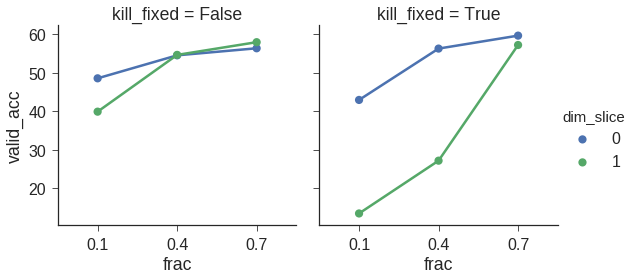

In [125]:
df = pd.DataFrame(ddd)
g = sns.factorplot(data=df[df.dim_slice<=1],x='frac',y='valid_acc',hue='dim_slice',col='kill_fixed')
#ax2_0 = g.axes[0][0].twinx()

In [98]:
#df=pd.DataFrame(data=all_opts,columns='frac,dataset,my_optimizer,arch,kill_fixed,iter_,to_train_only,learn_bn,dim_slice'.split(','))
#df.drop(columns=['my_optimizer','dataset','arch','to_train_only'])

,frac,kill_fixed,iter_,learn_bn,dim_slice
0,0.1,False,0,True,0
1,0.1,False,0,True,1
2,0.1,False,0,True,2
3,0.1,False,0,True,3
4,0.1,True,0,True,0
5,0.1,True,0,True,1
6,0.1,True,0,True,2
7,0.1,True,0,True,3
8,0.4,False,0,True,0
9,0.4,False,0,True,1


In [9]:
import torch
%pylab inline
a = torch.from_numpy(array(range(25)))





Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib


6.10348

In [85]:
%qtconsole

# Tiny-ImageNet

Populating the interactive namespace from numpy and matplotlib


/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


6.10348

In [24]:
%pylab inline
import torch
#a = torch.load('/home/amir/checkpoints/imagenet/wideresnet-full/checkpoint.pth.tar')
a = torch.load('/home/amir/checkpoints/imagenet/wideresnet-partial_0.1/model_best.pth.tar')
mtl = a['optimizer']['model_state_list']
sum(z.numel() for z in mtl)/10.**6
k = a['state_dict'].keys()

Populating the interactive namespace from numpy and matplotlib


In [98]:
fracs

[0,
 -1,
 0.1,
 0.4,
 0.7000000000000001,
 5,
 10,
 1,
 0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09]

# Weight Magnitude


-1
0.1
0.4
0.7


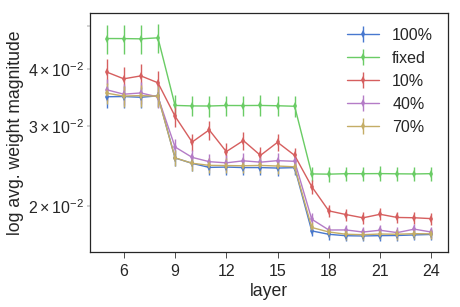

In [140]:
fracs = [-1,.1,.4,.7]
D = os.path.join(homedir,'checkpoints/imagenet')
close()
qqq=0
labels = []


plots = []
labels = []

P = []

for p in fracs:
    
    if p < 0:
        rrr = os.path.join(D,'wideresnet-full/model_best.pth.tar')
    else:
        rrr = os.path.join(D,'wideresnet-partial_{}/model_best.pth.tar'.format(p))
        
    a = torch.load(rrr)
    mtl = a['optimizer']['model_state_list']
    sum(z.numel() for z in mtl)/10.**6
    k = a['state_dict'].keys()
    aa = a['state_dict']#
    ff = []
    ffm = []
    ll = []
    llm = []
    for z in k:  
        if p > 0:
            if 'fixed' in z and 'Shortcut' not in z:      
                z1 = z.replace('fixed','learn')        
                q1 = aa[z].cpu().numpy().ravel()
                q2 = aa[z1].cpu().numpy().ravel()
                ff.append(q1.var());
                ll.append(q2.var());
                ffm.append(abs(q1).mean());
                llm.append(abs(q2).mean());
        elif 'conv' in z and 'weight' in z and 'Shortcut.weight' not in z:   
            #print '!!!'
            #print z
            #raise Exception()
            q1 = aa[z].cpu().numpy().ravel()
            llm.append(abs(q1).mean());
            ll.append(q1.var());
    #break
    r = range(len(ff))
    P.append(dict(frac=p,ffm=ffm,llm=llm,ff=ff,ll=ll))
    print p
    mmm = 5
    if False:
        if p == -1:        
            qqq+=1
            #labels.append('fixed')
            errorbar(r[mmm:],ffm[mmm:],yerr=ff[mmm:],label='fixed')

        #else:

        errorbar(r[mmm:],llm[mmm:],yerr=ll[mmm:],label='learned {}'.format(frac))
        qqq+=1
#gca().set_yscale("log", nonposx='clip')
#legend(['a','b','c','d','e'])
t=0
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
labels = []
close()
sns.set_palette('muted',5)
for p in P:
    if t==0 and len(p['ff'])>0:
        t=1
        labels.append('fixed')
        errorbar(r[mmm:],p['ffm'][mmm:],yerr=p['ff'][mmm:],linestyle='-',marker='d')
    #else:
    labels.append('100%' if p['frac']==-1 else '{}%'.format(int(100*p['frac'])))
    errorbar(r[mmm:],p['llm'][mmm:],yerr=p['ll'][mmm:],linestyle='-',marker='d')
gca().set_yscale("log", nonposx='clip')
legend(labels)
ylabel('log avg. weight magnitude')
xlabel('layer')
gca().xaxis.set_major_locator(MaxNLocator(integer=True))

savefig('/home/amir/Dropbox/publications/2018/icml2018_style/figures/magnitudes.pdf', bbox_inches='tight')

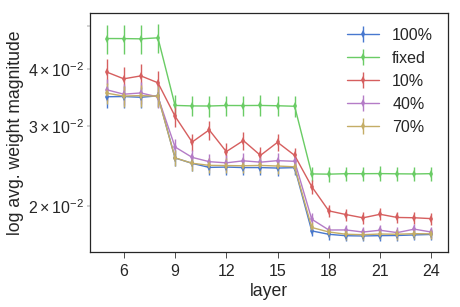

In [31]:
pd.DataFrame(P)

,ff,ffm,frac,ll,llm
0,[],[],-1.0,"[0.00047069267, 0.00047069267, 0.00047069267, ...","[0.017311418, 0.017311418, 0.017311418, 0.0173..."
1,"[0.012433259, 0.003447645, 0.0034907125, 0.003...","[0.08960941, 0.046959955, 0.047177907, 0.04716...",0.1,"[0.14676905, 0.008445142, 0.0027488857, 0.0029...","[0.29845607, 0.068580635, 0.040975586, 0.04190..."
2,"[0.014705522, 0.0035435236, 0.003454518, 0.003...","[0.09790056, 0.0469816, 0.046956852, 0.0471428...",0.4,"[0.07747602, 0.0044542127, 0.0021971967, 0.002...","[0.2285179, 0.051272668, 0.03707104, 0.0360143..."
3,"[0.015529061, 0.003572097, 0.0034653097, 0.003...","[0.0980911, 0.047527485, 0.046945486, 0.047279...",0.7,"[0.056743506, 0.0032702354, 0.0021190858, 0.00...","[0.18601906, 0.044425108, 0.036486756, 0.03530..."


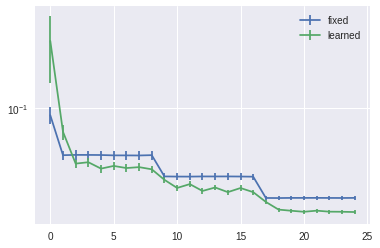

(array([1., 1., 1., 1., 6., 3., 6., 5., 2., 1.]),
 array([-1.01644945, -0.84031379, -0.66417812, -0.48804246, -0.31190679,
        -0.13577113,  0.04036454,  0.2165002 ,  0.39263587,  0.56877154,
         0.7449072 ]),
 <a list of 10 Patch objects>)

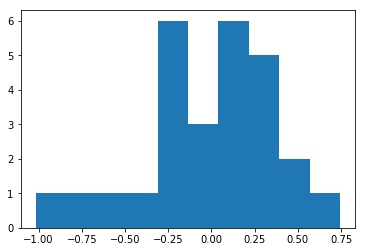

In [753]:
#hist(a['state_dict']['conv1.W_'].cpu().numpy().ravel())

In [744]:
a = torch.load('/home/amir/checkpoints/imagenet/wideresnet-partial_0.1/checkpoint.pth.tar')
mtl = a['optimizer']['model_state_list']
sum(z.numel() for z in mtl)/10.**6

0.829027

In [742]:
a = torch.load('/home/amir/checkpoints/imagenet/wideresnet-partial_0.4/checkpoint.pth.tar')
mtl = a['optimizer']['model_state_list']
sum(z.numel() for z in mtl)/10.**6

2.588682

In [743]:
a = torch.load('/home/amir/checkpoints/imagenet/wideresnet-partial_0.7/checkpoint.pth.tar')
mtl = a['optimizer']['model_state_list']
sum(z.numel() for z in mtl)/10.**6

4.339633

In [718]:
# (hese experiments were ran from a command line)
import os
homedir = '/home/amir/'
import pandas as pd
D = os.path.join(homedir,'checkpoints/imagenet')
fracs = [-1,.1,.4,.7]
results = []
for p in fracs:
    if p < 0:
        logFilePath = os.path.join(D,'wideresnet-full/log.txt')
        
    else:
        logFilePath = os.path.join(D,'wideresnet-partial_{}/log.txt'.format(p))
    logData = open(logFilePath).readlines()
    df = pd.read_table(logFilePath)
    curValidAcc = df['Valid Acc.'].max()
    curTrainAcc = df['Train Acc.'].max()
    results.append({'fraction':'all' if p < 0 else p,'Top-1 Perf %':curValidAcc,'Top-1 Perf(train) %':curTrainAcc})

In [719]:
results

[{'Top-1 Perf %': 35.54, 'Top-1 Perf(train) %': 40.118, 'fraction': 'all'},
 {'Top-1 Perf %': 21.75, 'Top-1 Perf(train) %': 23.821, 'fraction': 0.1},
 {'Top-1 Perf %': 30.13, 'Top-1 Perf(train) %': 33.635, 'fraction': 0.4},
 {'Top-1 Perf %': 33.22, 'Top-1 Perf(train) %': 37.192, 'fraction': 0.7}]

In [192]:
curValidAcc

2.36

# Toy Analysis

In [4]:
# Compute the effect of the gradient on a different number of layers.
from torch.nn import Parameter
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
from torch.optim import SGD
class split_linear(nn.Module):
    def __init__(self,M=100,N=100,l=10):
        super(split_linear, self).__init__()
        
        self.N = N
        f = N-l
        self.f = f 
        self.l = l            
        self.w1 = Parameter(torch.zeros(l,N));
        self.w1.requires_grad=True
        self.w2 = Parameter(torch.zeros(f,N));
        self.w2.requires_grad=False
                         
        nn.init.uniform(self.w1)
        nn.init.uniform(self.w2)
    def forward(self,x):
        #print 'data size:',x.shape
        w = torch.cat([self.w1,self.w2],dim=0)
        #print 'w size:',w.shape
        return torch.nn.functional.linear(x,w)
        
                      
        

In [227]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


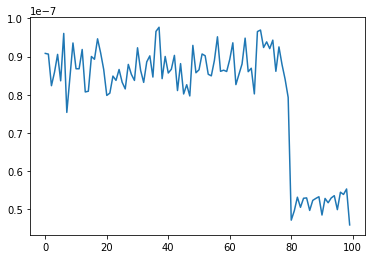

In [713]:
seq_len = 3
l = 80
z = []
for i in range(seq_len):
    z.append(split_linear(M=100,N=100,l=l)) 
    z.append(nn.ReLU())
    #z.append(nn.Sigmoid())
myModel = nn.Sequential(*z)
optimizer = SGD([p for p in myModel.parameters() if p.requires_grad],lr=.1)
#model = myModel
#for data,target in theDataset:
#    break
# 
data_scale = 1e-5
from copy import deepcopy
optimizer.zero_grad()
n_data_points=10000
data = Variable(torch.randn(n_data_points,100)*data_scale)
target = Variable(deepcopy(data).data*2)
output = myModel(data)


# show the output before and after.
#output_before = deepcopy(output.data)
before = deepcopy(output.data.numpy())
#print before[:5]
#print output_before[0,:5]
loss = torch.nn.functional.mse_loss(output, target)
loss.backward()
optimizer.step()
output_after = myModel(data)
after = output_after.data.numpy()
#print after[:5]

plot(abs((after-before)).mean(0))
#plot(abs(after-before))
#print output_after[0,:5]

In [292]:
before

numpy.ndarray

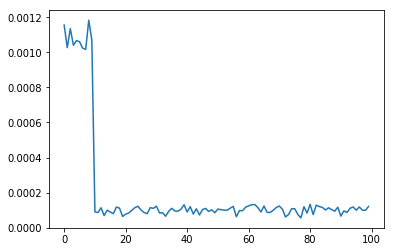

In [25]:
after

array([1.7836204, 1.7381306, 1.7763366, 1.7232119, 1.7602997, 1.819676 ,
       1.6148305, 1.7869694, 1.863014 , 1.9232671, 1.6675467, 1.9288261,
       1.7939003, 1.7023475, 1.7578208, 1.8411305, 1.6276453, 1.6983485,
       1.7128887, 1.7861323, 1.7639396, 1.7104216, 1.8112147, 1.845479 ,
       1.6940126, 1.8466477, 1.8214033, 1.8571067, 1.801799 , 1.6400363,
       1.82393  , 1.7039158, 1.7585746, 1.8790395, 1.7197676, 2.0646195,
       1.71238  , 2.007956 , 1.8907167, 1.6299839, 1.7504597, 1.6876549,
       1.739978 , 1.8075618, 1.8096602, 1.8362906, 1.7541611, 1.6808838,
       1.8950123, 1.6821353, 1.9598871, 1.747709 , 1.604775 , 1.7464929,
       1.5046725, 1.9774364, 1.7331359, 1.765638 , 1.7471405, 1.845999 ,
       1.9017458, 1.7360318, 1.8244516, 1.6148226, 1.7939175, 1.649965 ,
       1.6966695, 1.7754147, 1.8613366, 1.8397567, 1.8119464, 1.8632178,
       1.7026848, 1.802324 , 1.9371815, 1.6411607, 1.8709619, 1.9121945,
       1.7427374, 1.8045977, 1.7534587, 1.815068 , 

In [24]:
before

array([1.7836204, 1.7381306, 1.7763366, 1.7232119, 1.7602997, 1.819676 ,
       1.6148305, 1.7869694, 1.863014 , 1.9232671, 1.6675467, 1.9288261,
       1.7939003, 1.7023475, 1.7578208, 1.8411305, 1.6276453, 1.6983485,
       1.7128887, 1.7861323, 1.7639396, 1.7104216, 1.8112147, 1.845479 ,
       1.6940126, 1.8466477, 1.8214033, 1.8571067, 1.801799 , 1.6400363,
       1.82393  , 1.7039158, 1.7585746, 1.8790395, 1.7197676, 2.0646195,
       1.71238  , 2.007956 , 1.8907167, 1.6299839, 1.7504597, 1.6876549,
       1.739978 , 1.8075618, 1.8096602, 1.8362906, 1.7541611, 1.6808838,
       1.8950123, 1.6821353, 1.9598871, 1.747709 , 1.604775 , 1.7464929,
       1.5046725, 1.9774364, 1.7331359, 1.765638 , 1.7471405, 1.845999 ,
       1.9017458, 1.7360318, 1.8244516, 1.6148226, 1.7939175, 1.649965 ,
       1.6966695, 1.7754147, 1.8613366, 1.8397567, 1.8119464, 1.8632178,
       1.7026848, 1.802324 , 1.9371815, 1.6411607, 1.8709619, 1.9121945,
       1.7427374, 1.8045977, 1.7534587, 1.815068 , 

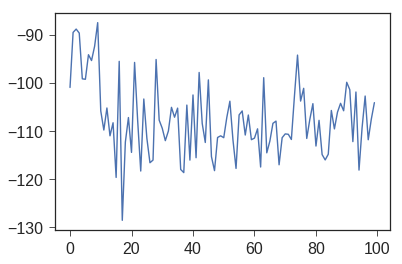

In [324]:

#data.shape
#target.shape

torch.Size([1, 100])

IndentationError: unexpected indent (<ipython-input-307-435974231273>, line 2)

In [183]:
import fnmatch
import os

matches = []
import shutil
old_dir = ''
for i,(root, dirnames, filenames) in enumerate(os.walk('/media/amir/newhd/')):
    if i % 100 == 0:
        print '.',
    for filename in fnmatch.filter(filenames, '*JPEG'):
        p= os.path.join(root, filename)
        new_p = p.replace('.JPEG','.jpg')
        shutil.move(p,new_p)

 . . . . . . . . . . . . . . . . . . . . .
